In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch
import gc
import psutil
import GPUtil

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Enable MLflow autologging for PyTorch
#mlflow.pytorch.autolog()
mlflow.set_tracking_uri(uri="file:///C:/Users/jcwin/OneDrive - University of Southampton/_Southampton/2024-25/Star-Classifier/mlflow")
mlflow.set_experiment("Fusion_Gaia_LAMOST")

<Experiment: artifact_location=('file:///C:/Users/jcwin/OneDrive - University of '
 'Southampton/_Southampton/2024-25/Star-Classifier/mlflow/286740436428343516'), creation_time=1729267230861, experiment_id='286740436428343516', last_update_time=1729267230861, lifecycle_stage='active', name='Fusion_Gaia_LAMOST', tags={}>

In [63]:
class ConvNetFusion(nn.Module):
    def __init__(self, input_shape, num_classes, gaia_input_size, 
                 num_filters=[128, 128, 128, 128, 128, 128, 128, 128], 
                 kernel_size=9,
                 dense_units=[256, 256, 256, 128, 128, 128, 64, 64, 64],
                 dropout_rate=0.2, 
                 gaia_fusion_units=512,
                 padding='same'):
        super(ConvNetFusion, self).__init__()
        
        self.conv_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()
        in_channels = 1  # Since it's a 1D input
        
        # Add convolutional layers
        for filters in num_filters:
            conv_layer = nn.Conv1d(in_channels=in_channels, out_channels=filters, kernel_size=kernel_size, padding=kernel_size//2)
            self.conv_layers.append(conv_layer)
            self.pool_layers.append(nn.MaxPool1d(kernel_size=2))
            self.dropout = nn.Dropout(dropout_rate)
            in_channels = filters
        
        # Flatten the output
        self.flatten = nn.Flatten()
        final_seq_len = input_shape[0] // (2 ** len(num_filters)) * num_filters[-1]
        print("Size of the flattened output:", final_seq_len)

        # Add Gaia features to the input
        self.gaia_input_layer = nn.Linear(gaia_input_size, gaia_fusion_units)

        # Add dense layers
        dense_input_units = final_seq_len + gaia_fusion_units  # Add Gaia features to the dense input
        print("Dense input units:", dense_input_units)
        print("Final sequence length:", final_seq_len)
        print("Number of filters:", num_filters[-1])
        self.dense_layers = nn.ModuleList()
        for units in dense_units:
            self.dense_layers.append(nn.Linear(dense_input_units, units))
            dense_input_units = units
        
        # Output layer
        self.output_layer = nn.Linear(dense_input_units, num_classes)

    
    
    def forward(self, x_conv, x_gaia):
        # Pass through convolutional layers
        for conv_layer, pool_layer in zip(self.conv_layers, self.pool_layers):
            x_conv = pool_layer(torch.relu(conv_layer(x_conv)))
            x_conv = self.dropout(x_conv)
        # Flatten the conv output
        x_conv = self.flatten(x_conv)

        # Connect Gaia features to a separate dense layer and connect after to the main network
        x_gaia = torch.relu(self.gaia_input_layer(x_gaia))

        # Concatenate Gaia features
        x = torch.cat((x_conv, x_gaia), dim=1)
        
        # Pass through dense layers
        for dense_layer in self.dense_layers:
            x = torch.relu(dense_layer(x))
            x = self.dropout(x)
        
        # Output layer
        x = self.output_layer(x)
        return torch.softmax(x, dim=1)



# Create Datasets
class BalancedDatasetFusion(Dataset):
    def __init__(self, X_conv, X_gaia, y, limit_per_label=1600):
        self.X_conv = X_conv
        self.X_gaia = X_gaia
        self.y = y
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.indices = self.balance_classes()

    def balance_classes(self):
        indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        np.random.shuffle(indices)
        return indices

    def re_sample(self):
        self.indices = self.balance_classes()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return self.X_conv[index], self.X_gaia[index], self.y[index]

# Define a function to train the model
def train_model(model, train_loader, val_loader, test_loader, num_epochs=200, lr=1e-4, patience=10):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    early_stopping_counter = 0
    best_test_loss = float('inf')
    epochs_no_improve = 0
    best_model = None

    for epoch in range(num_epochs):
        # Re-sample the training dataset at the start of each epoch
        train_loader.dataset.re_sample()
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0

        # Training loop
        for X_conv, X_gaia, y in train_loader:
            optimizer.zero_grad()
            outputs = model(X_conv, X_gaia)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_conv.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == y).sum().item()
            total_train += y.size(0)

        train_loss /= len(train_loader.dataset)
        train_acc = correct_train / total_train

        # Validation loop
        model.eval()
        val_loss, correct_val, total_val, test_loss, correct_test, total_test = 0, 0, 0, 0, 0, 0

        with torch.no_grad():
            for X_conv, X_gaia, y in val_loader:
                outputs = model(X_conv, X_gaia)
                loss = criterion(outputs, y)
                val_loss += loss.item() * X_conv.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == y).sum().item()
                total_val += y.size(0)
        # Test loop
        with torch.no_grad():
            for X_conv, X_gaia, y in test_loader:
                outputs = model(X_conv, X_gaia)
                loss = criterion(outputs, y)
                test_loss += loss.item() * X_conv.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == y).sum().item()
                total_test += y.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = correct_val / total_val
        test_loss /= len(test_loader.dataset)
        test_acc = correct_test / total_test

        # Log metrics for MLflow
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_acc", val_acc, step=epoch)
        mlflow.log_metric("test_loss", test_loss, step=epoch)
        mlflow.log_metric("test_acc", test_acc, step=epoch)


        # Early stopping
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered.")
                break

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


    # Load the best model weights before returning
    model.load_state_dict(best_model)
    return model

# Function to print confusion matrix and log it with MLflow
def print_confusion_matrix(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_conv, X_gaia, y in val_loader:
            outputs = model(X_conv, X_gaia)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Log confusion matrix
    mlflow.log_artifact(confusion_matrix_to_image(cm), artifact_path="confusion_matrix")

def confusion_matrix_to_image(cm):
    # Convert confusion matrix to an image (optional)
    import matplotlib.pyplot as plt
    import seaborn as sns
    import io

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    xticklabels=['Star', 'Binary Star', 'Galaxy', 'AGN']
    yticklabels=['Star', 'Binary Star', 'Galaxy', 'AGN']

    # Save the figure to a buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    
    # Return the buffer
    return buf


In [24]:
if __name__ == "__main__":
        # Load and preprocess data
        X = pd.read_pickle("Pickles/fusionv0/train.pkl")
        gaia_features = ["parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", "pmra", "pmdec", "pmra_error", "pmdec_error", 
        "phot_g_mean_flux", "flagnopllx", "phot_g_mean_flux_error", "phot_bp_mean_flux", "phot_rp_mean_flux", 
        "phot_bp_mean_flux_error", "phot_rp_mean_flux_error"]

        # Extract Gaia and LASMOST data
        X_gaia = X[gaia_features].values
        X_conv = X.drop(gaia_features + ["label"], axis=1).values
        y = X["label"]

        # Mapping labels to integers
        label_mapping = {'star': 0, 'binary_star': 1, 'galaxy': 2, 'agn': 3}
        y = y.map(label_mapping).values

        # Read test data
        X_test = pd.read_pickle("Pickles/fusionv0/test.pkl")
        X_test_gaia = X_test[gaia_features].values
        X_test_conv = X_test.drop(gaia_features + ["label"], axis=1).values
        y_test = X_test["label"]
        y_test = y_test.map(label_mapping).values


        # Split data into train and validation
        X_train_conv, X_val_conv, X_train_gaia, X_val_gaia, y_train, y_val = train_test_split(X_conv, X_gaia, y, test_size=0.2, random_state=42)

        # Convert to PyTorch tensors
        X_train_conv = torch.tensor(X_train_conv, dtype=torch.float32).unsqueeze(1)
        X_val_conv = torch.tensor(X_val_conv, dtype=torch.float32).unsqueeze(1)
        X_train_gaia = torch.tensor(X_train_gaia, dtype=torch.float32)
        X_val_gaia = torch.tensor(X_val_gaia, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.long)
        y_val = torch.tensor(y_val, dtype=torch.long)
        X_test_conv = torch.tensor(X_test_conv, dtype=torch.float32).unsqueeze(1)
        X_test_gaia = torch.tensor(X_test_gaia, dtype=torch.float32)
        y_test = torch.tensor(y_test, dtype=torch.long)

        # Create DataLoaders
        train_dataset = BalancedDatasetFusion(X_train_conv, X_train_gaia, y_train)
        val_dataset = BalancedDatasetFusion(X_val_conv, X_val_gaia, y_val)
        test_dataset = BalancedDatasetFusion(X_test_conv, X_test_gaia, y_test)

        train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# BB

In [64]:
import torch
import torch.nn as nn

# Define the Spectra Branch as a separate module
class SpectraBranch(nn.Module):
    def __init__(self, input_shape, num_classes, 
                 num_filters=[128, 128, 128, 128, 128, 128, 128, 128], 
                 kernel_size=9,
                 dropout_rate=0.2, padding='same'):
        super(SpectraBranch, self).__init__()
        
        self.conv_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()
        in_channels = 1  # Since it's a 1D input
        
        # Add convolutional layers
        for filters in num_filters:
            conv_layer = nn.Conv1d(in_channels=in_channels, out_channels=filters, kernel_size=kernel_size, padding=kernel_size//2)
            self.conv_layers.append(conv_layer)
            self.pool_layers.append(nn.MaxPool1d(kernel_size=2))
            in_channels = filters
        
        self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        for conv_layer, pool_layer in zip(self.conv_layers, self.pool_layers):
            x = pool_layer(torch.relu(conv_layer(x)))
            x = self.dropout(x)
        x = self.flatten(x)
        return x

# Define the Gaia Branch as a separate module
class GaiaBranch(nn.Module):
    def __init__(self, gaia_input_size, gaia_fusion_units):
        super(GaiaBranch, self).__init__()
        self.fc = nn.Linear(gaia_input_size, gaia_fusion_units)

    def forward(self, x):
        return torch.relu(self.fc(x))

# Fusion Model that combines both branches
class ConvNetFusion(nn.Module):
    def __init__(self, input_shape, num_classes, gaia_input_size, 
                 num_filters=[128, 128, 128, 128, 128, 128, 128, 128],  # More filters for SpectraBranch
                 kernel_size=9,
                 dense_units=[256, 128, 64, 32],
                 dropout_rate=0.2, 
                 gaia_fusion_units=10000):
        super(ConvNetFusion, self).__init__()

        # Instantiate the two branches
        self.spectra_branch = SpectraBranch(input_shape, num_classes, num_filters, kernel_size, dropout_rate)
        self.gaia_branch = GaiaBranch(gaia_input_size, gaia_fusion_units)

        # Fused input size
        fused_input_size = gaia_fusion_units + num_filters[-1] * (input_shape[0] // (2 ** len(num_filters)))
        
        # Fully connected layers after fusion
        for i, units in enumerate(dense_units):
            if i == 0:
                self.dense_layers = nn.Sequential(
                    nn.Linear(fused_input_size, units),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate)
                )
            else:
                self.dense_layers.add_module(f"dense_{i}", nn.Linear(dense_units[i-1], units))
                self.dense_layers.add_module(f"relu_{i}", nn.ReLU())
                self.dense_layers.add_module(f"dropout_{i}", nn.Dropout(dropout_rate))

        # Output layer
        self.output_layer = nn.Linear(dense_units[-1], num_classes)

    def forward(self, x_conv, x_gaia):
        # Spectra branch forward pass
        x_conv = self.spectra_branch(x_conv)
        
        # Gaia branch forward pass
        x_gaia = self.gaia_branch(x_gaia)
        
        # Concatenate the two branches
        x_fused = torch.cat((x_conv, x_gaia), dim=1)

        # Pass through dense layers
        x = self.dense_layers(x_fused)

        # Output layer
        x = self.output_layer(x)
        
        return torch.softmax(x, dim=1)
# Initialize toy model
gaia_input_size = X_train_gaia.shape[1]
print(f"Gaia input size: {gaia_input_size}")
filters = [16, 16, 32, 32, 32, 64, 64,64, 128, 128, 128]
dense=[256, 256 , 256 ,128, 64, 32]

model = ConvNetFusion(input_shape=(3748,), num_classes=4, gaia_input_size=gaia_input_size, 
                      num_filters=filters, kernel_size=9, dense_units=dense, dropout_rate=0.2, gaia_fusion_units=128)
# Save the model
torch.save(model, "Models/toyv0.pth")
# Print model summary
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


Gaia input size: 17
ConvNetFusion(
  (spectra_branch): SpectraBranch(
    (conv_layers): ModuleList(
      (0): Conv1d(1, 16, kernel_size=(9,), stride=(1,), padding=(4,))
      (1): Conv1d(16, 16, kernel_size=(9,), stride=(1,), padding=(4,))
      (2): Conv1d(16, 32, kernel_size=(9,), stride=(1,), padding=(4,))
      (3-4): 2 x Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))
      (5): Conv1d(32, 64, kernel_size=(9,), stride=(1,), padding=(4,))
      (6-7): 2 x Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,))
      (8): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (9-10): 2 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    )
    (pool_layers): ModuleList(
      (0-10): 11 x MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (gaia_branch): GaiaBranch(
    (fc): Linear(in_features=17, out_features=1

# Bunda bebe

In [66]:
# Training parameters
num_epochs = 200
lr = 1e-3
patience = 20
batch_size = 512

# Start an MLflow run
with mlflow.start_run(log_system_metrics=True):
    # Log parameters
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("lr", lr)
    mlflow.log_param("patience", patience)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_filters", filters)
    mlflow.log_param("dense_units", dense)
    mlflow.log_param("dropout_rate", 0.2)
    mlflow.log_param("kernel_size", 20)

    # Train the model
    trained_model = train_model(model, train_loader, val_loader, test_loader, num_epochs=num_epochs, lr=lr, patience=patience)

    # Evaluate the model
    print_confusion_matrix(trained_model, train_loader)
    # Save the model in MLflow
    #mlflow.pytorch.log_model(trained_model, "model")

2024/10/21 17:26:55 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/10/21 17:26:55 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:27:05 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:27:15 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [1/200], Train Loss: 1.2775, Train Acc: 0.4439, Val Loss: 1.2302, Val Acc: 0.5581, Test Loss: 1.2283, Test Acc: 0.5589


2024/10/21 17:27:25 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:27:35 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [2/200], Train Loss: 1.1011, Train Acc: 0.6480, Val Loss: 1.1058, Val Acc: 0.6130, Test Loss: 1.1093, Test Acc: 0.6084


2024/10/21 17:27:45 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:27:55 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [3/200], Train Loss: 1.0670, Train Acc: 0.6556, Val Loss: 1.0899, Val Acc: 0.6358, Test Loss: 1.0914, Test Acc: 0.6312


2024/10/21 17:28:05 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:28:16 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [4/200], Train Loss: 1.0487, Train Acc: 0.6721, Val Loss: 1.0785, Val Acc: 0.6261, Test Loss: 1.0797, Test Acc: 0.6225


2024/10/21 17:28:26 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:28:36 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [5/200], Train Loss: 1.0464, Train Acc: 0.6631, Val Loss: 1.0736, Val Acc: 0.6278, Test Loss: 1.0737, Test Acc: 0.6265


2024/10/21 17:28:46 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:28:56 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [6/200], Train Loss: 1.0242, Train Acc: 0.6912, Val Loss: 1.0626, Val Acc: 0.6323, Test Loss: 1.0624, Test Acc: 0.6341


2024/10/21 17:29:06 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:29:16 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [7/200], Train Loss: 1.0269, Train Acc: 0.6872, Val Loss: 1.0575, Val Acc: 0.6360, Test Loss: 1.0594, Test Acc: 0.6347


2024/10/21 17:29:26 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:29:36 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:29:46 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [8/200], Train Loss: 1.0175, Train Acc: 0.6963, Val Loss: 1.0540, Val Acc: 0.6432, Test Loss: 1.0548, Test Acc: 0.6424


2024/10/21 17:29:56 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:30:06 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [9/200], Train Loss: 1.0120, Train Acc: 0.7030, Val Loss: 1.0490, Val Acc: 0.6787, Test Loss: 1.0475, Test Acc: 0.6806


2024/10/21 17:30:17 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:30:27 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [10/200], Train Loss: 1.0031, Train Acc: 0.7283, Val Loss: 1.0324, Val Acc: 0.7108, Test Loss: 1.0307, Test Acc: 0.7160


2024/10/21 17:30:37 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:30:47 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [11/200], Train Loss: 0.9945, Train Acc: 0.7508, Val Loss: 1.0092, Val Acc: 0.7326, Test Loss: 1.0085, Test Acc: 0.7344


2024/10/21 17:30:57 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:31:07 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [12/200], Train Loss: 0.9687, Train Acc: 0.7713, Val Loss: 0.9955, Val Acc: 0.7418, Test Loss: 0.9927, Test Acc: 0.7456


2024/10/21 17:31:17 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:31:27 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [13/200], Train Loss: 0.9618, Train Acc: 0.7749, Val Loss: 0.9839, Val Acc: 0.7572, Test Loss: 0.9782, Test Acc: 0.7626


2024/10/21 17:31:37 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:31:47 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [14/200], Train Loss: 0.9471, Train Acc: 0.7958, Val Loss: 0.9871, Val Acc: 0.7544, Test Loss: 0.9842, Test Acc: 0.7546


2024/10/21 17:31:57 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:32:07 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [15/200], Train Loss: 0.9494, Train Acc: 0.7941, Val Loss: 0.9699, Val Acc: 0.7704, Test Loss: 0.9624, Test Acc: 0.7780


2024/10/21 17:32:18 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:32:28 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:32:38 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [16/200], Train Loss: 0.9377, Train Acc: 0.8048, Val Loss: 0.9666, Val Acc: 0.7751, Test Loss: 0.9586, Test Acc: 0.7803


2024/10/21 17:32:48 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:32:58 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [17/200], Train Loss: 0.9283, Train Acc: 0.8145, Val Loss: 0.9621, Val Acc: 0.7780, Test Loss: 0.9564, Test Acc: 0.7846


2024/10/21 17:33:08 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:33:18 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [18/200], Train Loss: 0.9348, Train Acc: 0.8061, Val Loss: 0.9692, Val Acc: 0.7733, Test Loss: 0.9629, Test Acc: 0.7786


2024/10/21 17:33:28 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:33:38 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:33:48 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [19/200], Train Loss: 0.9302, Train Acc: 0.8128, Val Loss: 0.9606, Val Acc: 0.7811, Test Loss: 0.9565, Test Acc: 0.7852


2024/10/21 17:33:58 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:34:08 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [20/200], Train Loss: 0.9359, Train Acc: 0.8061, Val Loss: 0.9573, Val Acc: 0.7848, Test Loss: 0.9516, Test Acc: 0.7915


2024/10/21 17:34:19 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:34:29 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [21/200], Train Loss: 0.9373, Train Acc: 0.8043, Val Loss: 0.9502, Val Acc: 0.7903, Test Loss: 0.9445, Test Acc: 0.7969


2024/10/21 17:34:39 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:34:49 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [22/200], Train Loss: 0.9313, Train Acc: 0.8117, Val Loss: 0.9479, Val Acc: 0.7924, Test Loss: 0.9404, Test Acc: 0.8018


2024/10/21 17:34:59 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:35:09 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [23/200], Train Loss: 0.9188, Train Acc: 0.8235, Val Loss: 0.9441, Val Acc: 0.7981, Test Loss: 0.9372, Test Acc: 0.8029


2024/10/21 17:35:19 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:35:29 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.


Epoch [24/200], Train Loss: 0.9187, Train Acc: 0.8240, Val Loss: 0.9466, Val Acc: 0.7934, Test Loss: 0.9380, Test Acc: 0.8053


2024/10/21 17:35:39 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Unknown Error when trying to collect GPU metrics.
2024/10/21 17:35:43 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/10/21 17:35:43 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


KeyboardInterrupt: 

Confusion Matrix:
[[1227  349    3   21]
 [ 374 1199    7   20]
 [   1    0  327    7]
 [  43   12  214 1331]]


TypeError: stat: path should be string, bytes, os.PathLike or integer, not BytesIO

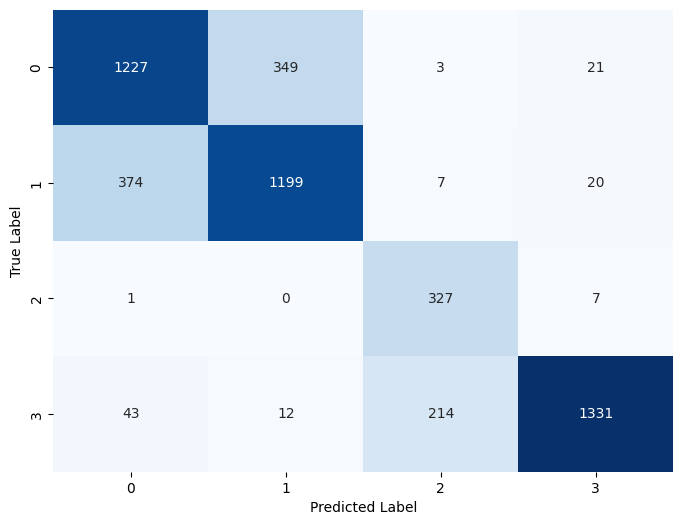

In [68]:
print_confusion_matrix(trained_model, val_loader)


In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [11]:
# Confusion matrix and classification report
def print_confusion_matrix(model, val_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            preds = model(X_batch).cpu().numpy()
            all_preds.extend(np.argmax(preds, axis=1))
            all_labels.extend(y_batch.numpy())

    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['Star', 'Binary Star', 'Galaxy', 'AGN'], 
                yticklabels=['Star', 'Binary Star', 'Galaxy', 'AGN'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
